# CNN WITHOUT GAN AUGMENTATION

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
image_size = 256
batch_size = 10 #number of image for each trainning
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean
DIR_All='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/Newdata/Train/All_in'
folder_All = ImageFolder(DIR_All, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
train_All = DataLoader(folder_All, batch_size, shuffle=True, num_workers=3)

* The dataset is loaded from the folder after being normalized to the mean value and transformed to tensor.
* It is divided into 82/batch_size steps to be trained one by one.
* The trained set is shuffled each epochs to gain randomness. 

In [17]:
DIR_Test='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/Newdata/Test'
folder_Test = ImageFolder(DIR_Test, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
test_All = DataLoader(folder_Test, batch_size, shuffle=False, num_workers=3)#, pin_memory=True)

* The test data set is loaded similarly but without being shuffled

In [18]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

* The normalized range of the image is returned into the original pixel range to be able to be represented in a batch group.

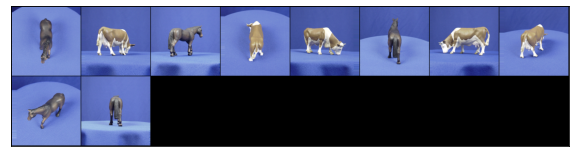

In [19]:
show_batch(train_All)

* As can be seen, the data of cow and horse is stored in separated folder but is still mixed into one and; therfore, labeled automatically by the different folder marks.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Sublayer(nn.Module):
    def __init__(self, input_channels):
        super(Sublayer, self).__init__()
        self.conv = nn.Conv2d(input_channels, input_channels*2, 4, 2, 1)
        self.batch= nn.BatchNorm2d(input_channels*2)
        self.relu =nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x
    def get_self(self):
        return self
    
class NetClass(nn.Module):
    def __init__(self):
        super(NetClass, self).__init__()
        self.conv = nn.Conv2d(3, 16, 4, 2, 1)
        self.batch= nn.BatchNorm2d(16)
        self.relu =nn.ReLU(True)
        self.lay1=Sublayer(16)
        self.lay2=Sublayer(32)
        self.lay3=Sublayer(64)
        self.lay4=Sublayer(128)
        self.lay5=Sublayer(256)
        self.lay6=Sublayer(512)
        self.maxpool =nn.MaxPool2d((2,2))
        self.fc = nn.Linear(1024,2)
    def forward(self,x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.lay1(x)
        x = self.lay2(x)
        x = self.lay3(x)
        x = self.lay4(x)
        x = self.lay5(x)
        x = self.lay6(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), 1024)
        x = self.fc(x)
        return x
net = NetClass()

* The CNN model is generated by convolutional layers and a fully connected layer with 2 output neuron with the trained weight connecting the highlighted positions with corresponding labels. 
* convolutional layers contains 6 sublayers formed by Conv2D, BatchNorm2d and ReLU. 

In [21]:
from torchsummary import summary
model=NetClass()
summary(model,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             784
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4           [-1, 32, 64, 64]           8,224
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
          Sublayer-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 32, 32]          32,832
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
         Sublayer-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 128, 16, 16]         131,200
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

* As can be seen in the summary, the initial shape of the image (3*256*256) is expanded in channels and decomposed in the number of height and width. It eventually gives the output of 1024*1*1 with the help of MaxPool2d layer to activate significant features.
* That output shape is made to be similar with the column feature vector to be more straightly connected to the 2 neurons without being rearranged through a Flatten step.

In [36]:
x = torch.zeros(18, 3, 256, 256)
scores = model(x)
print(scores.shape)

torch.Size([18, 2])


* As tested for the output shape of the model, there are 2 output features for 18 input batches.

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0002)#, momentum=0.9)

* The criterion between the probability of 2 distributions is set for CrossEntropyLoss function for the relation between the trained data and their corresponding labels marked by different folder.
* The weight in each iteration is updated through the implemenation of stochastic gradient descent SGD in each parameter of the model with a slowly decaying learning rate 0.0002.

In [24]:
# Train the model
import numpy as np
total_step = len(train_All)
loss_list = []
acc_list = []
num_epochs = 10

for epoch in range(num_epochs):
    for i, (data,label) in enumerate(train_All):
        outputs = net(data)
        loss = criterion(outputs, label)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = label.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == label).sum().item()
        acc_list.append(correct / total)

       
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/10], Step [1/9], Loss: 0.9476, Accuracy: 40.00%
Epoch [1/10], Step [2/9], Loss: 0.5951, Accuracy: 70.00%
Epoch [1/10], Step [3/9], Loss: 0.7675, Accuracy: 50.00%
Epoch [1/10], Step [4/9], Loss: 0.5940, Accuracy: 60.00%
Epoch [1/10], Step [5/9], Loss: 0.4041, Accuracy: 80.00%
Epoch [1/10], Step [6/9], Loss: 0.7380, Accuracy: 40.00%
Epoch [1/10], Step [7/9], Loss: 0.5560, Accuracy: 50.00%
Epoch [1/10], Step [8/9], Loss: 0.6453, Accuracy: 40.00%
Epoch [1/10], Step [9/9], Loss: 1.3868, Accuracy: 0.00%
Epoch [2/10], Step [1/9], Loss: 0.3968, Accuracy: 100.00%
Epoch [2/10], Step [2/9], Loss: 0.3969, Accuracy: 100.00%
Epoch [2/10], Step [3/9], Loss: 0.4752, Accuracy: 80.00%
Epoch [2/10], Step [4/9], Loss: 0.5182, Accuracy: 70.00%
Epoch [2/10], Step [5/9], Loss: 0.4469, Accuracy: 90.00%
Epoch [2/10], Step [6/9], Loss: 0.5733, Accuracy: 70.00%
Epoch [2/10], Step [7/9], Loss: 0.3806, Accuracy: 90.00%
Epoch [2/10], Step [8/9], Loss: 0.3615, Accuracy: 100.00%
Epoch [2/10], Step [9/9], Los

* The training process consider iteratively in each epoch time SGD between the output CNN of the dataset in each divided batch and their labels. 
* The loss is improved through finding and backpropagating the derivatives of loss with the parameters as the gradient. To avoid accumumation of this gradient, zero_grad() is called at the beginning of each batch.
* The parameters/weight is updated one by one through the iterations by multiplication with the learning rate, which is called by .step().
* The data training including loss and accuracy in each training step is recorded for data analysis.

In [25]:
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_All:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(correct/total)

0.36585365853658536


* The evaluation/accuracy is implemented on the test set by considering the output of the trained model which is 2 values representing the highlighted features predicted for each class justifed by mass/weight update in the training process.
* The location of the higher value between these parameters are compared to the real expected one in the test set to verify the accuracy.
* As can be seen due to the low amount of dataset, the accuracy for the classification task is low 36.59%.

In [48]:
PATH = 'CNN_without_GAN.pth'
torch.save(net.state_dict(), PATH)

* The trained parameters of the model is saved with a file name for the later use. 

In [53]:
it=[i for i in range(len(loss_list))]
len(it)

300

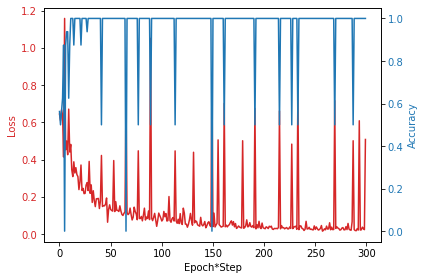

In [54]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch*Step')
ax1.set_ylabel('Loss', color=color)
ax1.plot(it, loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot(it, acc_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

* The changing trend of accuracy and loss is viasualized by ploting both of them through out the number of training times.
* As can be seen, the distance between CNN output parameters and the real labels are gradually decreasing through the training process, which is equivalent to the increment in the accuracy within the test dataset.
* However, the model seems overfit pretty quickly and gather every details of the correct target label but lose the generic characteristics for the larger dataset not contained in the given trained one. Therefore, the accuracy of the test set using this model is low.
* Because of this, the GAN method used to generate more data containing features belonging to the distribution of the dataset is taken into account.

# GAN implementation for COW

* The GAN model for horse class is trained before this GAN of cow and they both follow the same procedure. But it is the first training times for tests, therefore its quality is much lower than this cow version. Because the training section is time-consuming for my model, so the justified version applied for horse is still delayed. Therefore, it is taken as the performance comparison version with this cow class. 
* The horse GAN was conducted on collaboratory separately so it can not be merged into this general file due to the missing of parameters. So hopefully this brief discription can replace. 
* In particular, the horse GAN model is trained similarly to this cow's but their batch size is much larger (16), especially with the limited dataset; Which is expected to be the one differentiate the quality of these models.
* Moreover, its stopping stage is recorded at about 370 epochs. The model can generate clear shape at flat-side positions of the horse sample because they are less complex than others. The image representation and quality can be reviewed via report. 

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
dataset = 'C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/Newdata/Train/Cow_train/'

In [5]:
image_size = 256
batch = 8 #number of images for each trainning
norms = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean within the range from 0 to 1

* The images in cow samples are loaded in a 8 batch DataLoader, which is a half smaller than that of horse. This change can be the factor defining the improved performance of this cow GAN model. It can both reduce the training convergence time in each epoch and increase accuracy.

In [7]:
train_ds = ImageFolder(dataset, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*norms)])) #input data from directory to pre-process it to fit with tensor form and normalization

In [24]:
train_dl = DataLoader(train_ds, batch, shuffle=True, num_workers=3, pin_memory=True) #select random batch number of image for training section

In [10]:
def denorm(image): # return the tensor image back into original form
    return image * norms[1][0] + norms[0][0]

In [11]:
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

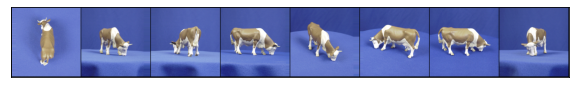

In [25]:
show_batch(train_dl)

In [4]:
def get_default_device():#searching for the device receiving the data and support the trainning process
    if torch.cuda.is_available():#checking if GPU is available
        return torch.device('cuda')#if yes, taking it as GPU
    else:
        return torch.device('cpu')#else use CPU instead
    
def to_device(data, device):#load the data under the tensor form to the device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():#Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device 
    def __iter__(self):#Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):#batch_size
        return len(self.dl)

* The Processors can support the speed of the training process so it is supported by torch so that tensor data images can be loaded into the available processor.

In [5]:
device = get_default_device()
device

device(type='cpu')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)#loading the DataLoader into the processor

In [8]:
discriminator = nn.Sequential(
    # in: 3 x 256 x 256

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 128 x 128

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 32 x 32

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 16 x 16

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 8 x 8

    nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2048),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 2048 x 4 x 4

    nn.Conv2d(2048, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

* The discriminator is composed of a sequence of 6 sublayers each which contains Conv2d to double the channel and halve the image size in a (4,4) window sliding through the tensor by step/stride 2, BatchNorm2d with the same output channel size of the Conv2d and the LeakyReLU which acts as the activation for the positive signigicant values of the input tensor.
* The model is finallized by the a flatten layer to convert the output size 1*1*1 into a vector before being normalized for probability representation by Sigmoid().
* Therefore, as can be witnessed in the summary table, the output of the whole process is a scalar probability value serving for the discriminating task.

In [9]:
from torchsummary import summary
summary(discriminator,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         LeakyReLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
       BatchNorm2d-8          [-1, 256, 32, 32]             512
         LeakyReLU-9          [-1, 256, 32, 32]               0
           Conv2d-10          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-11          [-1, 512, 16, 16]           1,024
        LeakyReLU-12          [-1, 512, 16, 16]               0
           Conv2d-13           [-1, 1024, 8, 8]       8,388,608
      BatchNorm2d-14           [-1, 102

In [13]:
discriminator = to_device(discriminator, device)

* The model is then loaded into the device.

In [10]:
latent = 128#defining the input size of latent random-value space

In [13]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent, 2048, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(2048),
    nn.ReLU(True),
    # out: 2048 x 4 x 4

    nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 8 x 8

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 16 x 16

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 32 x 32

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 64 x 64

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 128 x 128

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 256 x 256
)

* The generator is the transposed version of the discriminator aiming to generate the original image size from the input given latent space.
* Therefore, it is composed of Transpose-Convolutional sublayers with inversely corresponding parameters to reverse the process of the discriminator. By doing this the output shape of the image (3 x 256 x 256) is eventually obtained at the end of the model.

In [18]:
summary(generator,(latent,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 2048, 4, 4]       4,194,304
       BatchNorm2d-2           [-1, 2048, 4, 4]           4,096
              ReLU-3           [-1, 2048, 4, 4]               0
   ConvTranspose2d-4           [-1, 1024, 8, 8]      33,554,432
       BatchNorm2d-5           [-1, 1024, 8, 8]           2,048
              ReLU-6           [-1, 1024, 8, 8]               0
   ConvTranspose2d-7          [-1, 512, 16, 16]       8,388,608
       BatchNorm2d-8          [-1, 512, 16, 16]           1,024
              ReLU-9          [-1, 512, 16, 16]               0
  ConvTranspose2d-10          [-1, 256, 32, 32]       2,097,152
      BatchNorm2d-11          [-1, 256, 32, 32]             512
             ReLU-12          [-1, 256, 32, 32]               0
  ConvTranspose2d-13          [-1, 128, 64, 64]         524,288
      BatchNorm2d-14          [-1, 128,

torch.Size([8, 3, 256, 256])


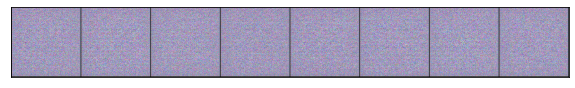

In [28]:
xb = torch.randn(batch, latent, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

* As can be seen, the generator is able to generate the images but they are rooted from noise; therefore, the generator's parameters need to be trained to obtain the ability to synthesize ones with the same distribution of the given class.

In [29]:
generator = to_device(generator, device)#load the generator to the device

In [18]:
def train_discriminator(real_images, opt_d):#train the discriminator with the input optimizer
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent_space = torch.randn(batch, latent, 1, 1, device=device)
    fake_images = generator(latent_space)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

* The discriminator is trained in 2 parallel sections. The first one is the ability to distinguish the real images by updating the weight connecting the output probability to be close to the given label (1). The second one is the fake image classification generated by the generator from the latent space. By doing this both of the model are able to be trained simutaneously and support each other to accomplish their task eventually.
* The evaluation is cross entropy function for binary case (fake/real). The loss is the loss summation of these two sections.

In [19]:
def train_generator(opt_g):#train the generator with the input optimizer
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent_space = torch.randn(batch, latent, 1, 1, device=device)
    fake_images = generator(latent_space)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

* In parallel, the generator is also trained with the same criterion but the task is to fool the discriminator by attaching the true label on the prediction of the discriminator for the fake images it generates.

In [30]:
input_latent = torch.randn(9, latent, 1, 1, device=device) #random torch-form values are created with 9 images in latent size for training and creating new GAN images

In [31]:
def fit(epochs, lr, start_idx=1):
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
       
    return losses_g, losses_d, real_scores, fake_scores


* The general training function is the process running through the batch size in each iteration of epoch. The real image is taken from the dataloader for distinguishing process of discriminator which is trained in parallel with the generator. The input optimizers for both of them is defined by Adam, a higher-efficiency replacement of SGD, with learning rate =0.0002 controlled by decaying parameters betas.
* The output of this model is the losses of the two models along with the score of them considering the average values of the predicted probability for real samples and fake samples in the discriminator.

In [32]:
def save_model(generator,discriminator, data_training,th):
    model_th=generator
    PATH = 'model_cow{}.pt'.format(th)
    torch.save(model_th, PATH)
    
    PATH_dist='dist_cow{}.pt'.format(th)
    dist_th=discriminator
    torch.save(dist_th,PATH_dist)

    data_th = torch.tensor(data_training)
    torch.save(data_th, 'data_training{}.pt'.format(th))

* The save_model function takes into account the data storage of the trained generator and discriminator models along with the data recorded from the fit() function for losses and scores.

In [34]:
lr = 0.0002 # learning rate

* Afer several training times, it is indicated that my model gives low image quality for the first 300 epochs, therefore; it is trained altogether with 120 epochs for 2 first times and 60 epochs for the third ones.
* After that, the number of epochs is reduced to about 5-10 justified in each training times to search and record the one obtaining acceptable images. The save_model() is used after each trainning time to save the parameters for analysis.

In [35]:
epochs = 120
training1 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/120], loss_g: 31.2424, loss_d: 0.5926, real_score: 1.0000, fake_score: 0.3525


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/120], loss_g: 32.8266, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/120], loss_g: 32.2761, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/120], loss_g: 27.9566, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/120], loss_g: 17.7949, loss_d: 0.1471, real_score: 1.0000, fake_score: 0.0869


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/120], loss_g: 10.7961, loss_d: 0.1189, real_score: 0.9960, fake_score: 0.0763


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/120], loss_g: 8.0613, loss_d: 0.5725, real_score: 1.0000, fake_score: 0.1544


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/120], loss_g: 6.8820, loss_d: 0.0565, real_score: 0.9998, fake_score: 0.0535


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/120], loss_g: 5.9326, loss_d: 0.0692, real_score: 0.9983, fake_score: 0.0571


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/120], loss_g: 9.1554, loss_d: 0.0063, real_score: 0.9971, fake_score: 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/120], loss_g: 14.7393, loss_d: 1.2801, real_score: 0.9987, fake_score: 0.5472


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/120], loss_g: 10.1666, loss_d: 0.0512, real_score: 0.9826, fake_score: 0.0325


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/120], loss_g: 5.7475, loss_d: 0.0680, real_score: 0.9977, fake_score: 0.0629


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/120], loss_g: 1.7318, loss_d: 1.1681, real_score: 0.3875, fake_score: 0.1842


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/120], loss_g: 3.9528, loss_d: 0.0276, real_score: 0.9938, fake_score: 0.0208


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/120], loss_g: 5.4648, loss_d: 0.0399, real_score: 0.9984, fake_score: 0.0367


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/120], loss_g: 6.1034, loss_d: 0.2778, real_score: 0.9999, fake_score: 0.1938


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/120], loss_g: 16.4573, loss_d: 5.2386, real_score: 0.9999, fake_score: 0.9414


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/120], loss_g: 4.9368, loss_d: 0.0412, real_score: 1.0000, fake_score: 0.0393


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/120], loss_g: 6.0533, loss_d: 0.0779, real_score: 0.9710, fake_score: 0.0465


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/120], loss_g: 4.4832, loss_d: 0.0404, real_score: 0.9958, fake_score: 0.0338


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/120], loss_g: 6.4806, loss_d: 0.0226, real_score: 0.9967, fake_score: 0.0191


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/120], loss_g: 1.1240, loss_d: 0.9418, real_score: 0.4606, fake_score: 0.1473


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/120], loss_g: 4.2914, loss_d: 0.2055, real_score: 0.9987, fake_score: 0.1445


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/120], loss_g: 10.0345, loss_d: 1.4102, real_score: 0.9999, fake_score: 0.6604


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/120], loss_g: 5.6196, loss_d: 0.0897, real_score: 0.9248, fake_score: 0.0115


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/120], loss_g: 4.7437, loss_d: 0.0155, real_score: 0.9994, fake_score: 0.0147


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/120], loss_g: 0.5157, loss_d: 1.3116, real_score: 0.2983, fake_score: 0.0915


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/120], loss_g: 3.6825, loss_d: 0.3327, real_score: 0.7915, fake_score: 0.0918


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/120], loss_g: 4.0878, loss_d: 0.4227, real_score: 0.8004, fake_score: 0.1573


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/120], loss_g: 1.4702, loss_d: 0.8537, real_score: 0.4276, fake_score: 0.0042


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/120], loss_g: 4.7177, loss_d: 0.0662, real_score: 0.9988, fake_score: 0.0621


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/120], loss_g: 12.8363, loss_d: 0.2508, real_score: 0.7782, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/120], loss_g: 4.5953, loss_d: 13.1138, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/120], loss_g: 6.9351, loss_d: 0.6056, real_score: 0.9837, fake_score: 0.4200


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/120], loss_g: 12.8594, loss_d: 4.3288, real_score: 0.9996, fake_score: 0.9819


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/120], loss_g: 2.2243, loss_d: 0.0924, real_score: 0.9844, fake_score: 0.0724


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/120], loss_g: 2.3197, loss_d: 0.1564, real_score: 0.9838, fake_score: 0.1262


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/120], loss_g: 2.3472, loss_d: 0.1111, real_score: 0.9793, fake_score: 0.0850


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/120], loss_g: 4.2868, loss_d: 0.7106, real_score: 0.9955, fake_score: 0.4582


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/120], loss_g: 3.4409, loss_d: 0.0266, real_score: 0.9962, fake_score: 0.0224


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/120], loss_g: 2.3442, loss_d: 1.3765, real_score: 0.2618, fake_score: 0.0333


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/120], loss_g: 0.4660, loss_d: 0.4891, real_score: 0.6346, fake_score: 0.0334


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/120], loss_g: 7.9296, loss_d: 0.2344, real_score: 0.9966, fake_score: 0.1878


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/120], loss_g: 6.2727, loss_d: 1.2493, real_score: 1.0000, fake_score: 0.6014


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/120], loss_g: 6.4322, loss_d: 0.4413, real_score: 0.9736, fake_score: 0.2542


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/120], loss_g: 2.7411, loss_d: 0.1349, real_score: 0.9780, fake_score: 0.1018


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/120], loss_g: 11.8311, loss_d: 1.8167, real_score: 0.9527, fake_score: 0.6979


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/120], loss_g: 4.8789, loss_d: 0.2700, real_score: 0.8275, fake_score: 0.0709


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/120], loss_g: 8.1055, loss_d: 0.1906, real_score: 0.8283, fake_score: 0.0022


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [51/120], loss_g: 7.0079, loss_d: 0.0731, real_score: 0.9838, fake_score: 0.0542


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [52/120], loss_g: 5.8080, loss_d: 0.0249, real_score: 0.9990, fake_score: 0.0232


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [53/120], loss_g: 8.7650, loss_d: 2.6068, real_score: 0.9999, fake_score: 0.8322


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [54/120], loss_g: 0.2584, loss_d: 1.7748, real_score: 0.2495, fake_score: 0.2668


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [55/120], loss_g: 3.0958, loss_d: 5.3171, real_score: 0.0050, fake_score: 0.0148


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [56/120], loss_g: 8.7424, loss_d: 0.4643, real_score: 0.9963, fake_score: 0.3165


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [57/120], loss_g: 1.7861, loss_d: 2.6549, real_score: 0.0766, fake_score: 0.0737


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [58/120], loss_g: 0.1195, loss_d: 1.9994, real_score: 0.1467, fake_score: 0.0755


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [59/120], loss_g: 5.3604, loss_d: 0.1424, real_score: 0.9879, fake_score: 0.1200


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [60/120], loss_g: 3.4003, loss_d: 0.4682, real_score: 0.8738, fake_score: 0.2692


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [61/120], loss_g: 6.5573, loss_d: 0.1106, real_score: 0.9156, fake_score: 0.0221


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [62/120], loss_g: 8.2154, loss_d: 0.1590, real_score: 0.8567, fake_score: 0.0044


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [63/120], loss_g: 14.1879, loss_d: 3.1767, real_score: 1.0000, fake_score: 0.9134


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [64/120], loss_g: 1.8065, loss_d: 0.9941, real_score: 0.4541, fake_score: 0.1828


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [65/120], loss_g: 6.4895, loss_d: 0.1502, real_score: 0.8847, fake_score: 0.0270


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [66/120], loss_g: 8.6461, loss_d: 1.2600, real_score: 0.9153, fake_score: 0.6279


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [67/120], loss_g: 7.3017, loss_d: 1.0003, real_score: 0.9985, fake_score: 0.5628


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [68/120], loss_g: 2.4690, loss_d: 0.5560, real_score: 0.6443, fake_score: 0.0856


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [69/120], loss_g: 9.5076, loss_d: 0.3799, real_score: 0.9820, fake_score: 0.2704


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [70/120], loss_g: 3.3875, loss_d: 0.2381, real_score: 0.9886, fake_score: 0.1813


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [71/120], loss_g: 5.7173, loss_d: 0.1694, real_score: 0.9955, fake_score: 0.1483


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [72/120], loss_g: 4.1592, loss_d: 0.5824, real_score: 0.5592, fake_score: 0.0010


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [73/120], loss_g: 8.6980, loss_d: 1.1483, real_score: 1.0000, fake_score: 0.5511


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [74/120], loss_g: 1.7251, loss_d: 1.1974, real_score: 0.3025, fake_score: 0.0017


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [75/120], loss_g: 13.7786, loss_d: 0.0173, real_score: 0.9838, fake_score: 0.0010


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [76/120], loss_g: 3.7142, loss_d: 0.2098, real_score: 0.9731, fake_score: 0.1468


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [77/120], loss_g: 6.9443, loss_d: 0.8934, real_score: 0.9807, fake_score: 0.4794


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [78/120], loss_g: 4.8190, loss_d: 0.9487, real_score: 1.0000, fake_score: 0.4763


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [79/120], loss_g: 2.4664, loss_d: 1.0940, real_score: 0.6678, fake_score: 0.3790


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [80/120], loss_g: 5.4624, loss_d: 0.0966, real_score: 0.9910, fake_score: 0.0824


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [81/120], loss_g: 9.2382, loss_d: 0.5402, real_score: 0.9989, fake_score: 0.3819


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [82/120], loss_g: 4.2877, loss_d: 0.5392, real_score: 0.9998, fake_score: 0.3178


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [83/120], loss_g: 8.1891, loss_d: 0.8520, real_score: 0.8282, fake_score: 0.4294


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [84/120], loss_g: 9.6324, loss_d: 5.6966, real_score: 0.0034, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [85/120], loss_g: 3.0075, loss_d: 0.1706, real_score: 0.9915, fake_score: 0.1471


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [86/120], loss_g: 2.7004, loss_d: 3.3411, real_score: 0.0363, fake_score: 0.0242


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [87/120], loss_g: 6.8058, loss_d: 0.0296, real_score: 0.9989, fake_score: 0.0276


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [88/120], loss_g: 6.3781, loss_d: 0.8163, real_score: 0.9902, fake_score: 0.4056


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [89/120], loss_g: 8.1294, loss_d: 0.2112, real_score: 0.9945, fake_score: 0.1820


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [90/120], loss_g: 6.5096, loss_d: 0.2413, real_score: 0.9969, fake_score: 0.1984


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [91/120], loss_g: 6.5832, loss_d: 0.0860, real_score: 0.9571, fake_score: 0.0411


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [92/120], loss_g: 4.8640, loss_d: 0.5838, real_score: 0.7378, fake_score: 0.2278


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [93/120], loss_g: 5.5105, loss_d: 0.0963, real_score: 0.9524, fake_score: 0.0448


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [94/120], loss_g: 0.0092, loss_d: 2.1083, real_score: 0.1234, fake_score: 0.0158


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [95/120], loss_g: 5.9302, loss_d: 1.6750, real_score: 0.9886, fake_score: 0.7705


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [96/120], loss_g: 0.2439, loss_d: 1.8933, real_score: 0.1680, fake_score: 0.0979


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [97/120], loss_g: 5.3828, loss_d: 0.0665, real_score: 0.9847, fake_score: 0.0496


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [98/120], loss_g: 6.3044, loss_d: 0.1349, real_score: 0.8934, fake_score: 0.0217


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [99/120], loss_g: 9.7940, loss_d: 1.2644, real_score: 0.9785, fake_score: 0.6651


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [100/120], loss_g: 6.3095, loss_d: 0.2570, real_score: 0.7784, fake_score: 0.0064


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [101/120], loss_g: 10.7390, loss_d: 1.0407, real_score: 0.9938, fake_score: 0.5801


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [102/120], loss_g: 3.7319, loss_d: 0.5261, real_score: 0.5998, fake_score: 0.0148


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [103/120], loss_g: 8.3470, loss_d: 8.0362, real_score: 0.0003, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [104/120], loss_g: 0.4652, loss_d: 2.6672, real_score: 0.1051, fake_score: 0.2904


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [105/120], loss_g: 5.1721, loss_d: 4.1027, real_score: 0.0166, fake_score: 0.0029


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [106/120], loss_g: 4.0799, loss_d: 0.8632, real_score: 0.7352, fake_score: 0.3748


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [107/120], loss_g: 7.1562, loss_d: 0.3528, real_score: 0.7038, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [108/120], loss_g: 6.8753, loss_d: 0.4788, real_score: 0.9835, fake_score: 0.3026


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [109/120], loss_g: 4.7118, loss_d: 0.0223, real_score: 0.9978, fake_score: 0.0198


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [110/120], loss_g: 1.0833, loss_d: 2.2873, real_score: 0.1016, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [111/120], loss_g: 5.5510, loss_d: 0.0760, real_score: 0.9527, fake_score: 0.0268


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [112/120], loss_g: 4.8616, loss_d: 1.1189, real_score: 0.7060, fake_score: 0.5226


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [113/120], loss_g: 4.9541, loss_d: 0.0711, real_score: 0.9873, fake_score: 0.0563


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [114/120], loss_g: 5.0355, loss_d: 0.4089, real_score: 0.8630, fake_score: 0.2258


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [115/120], loss_g: 4.6083, loss_d: 0.1342, real_score: 0.9644, fake_score: 0.0927


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [116/120], loss_g: 1.6386, loss_d: 0.5888, real_score: 0.5790, fake_score: 0.0408


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [117/120], loss_g: 6.2231, loss_d: 0.0629, real_score: 0.9463, fake_score: 0.0076


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [118/120], loss_g: 4.9581, loss_d: 0.2929, real_score: 0.9509, fake_score: 0.1989


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [119/120], loss_g: 5.8558, loss_d: 0.1088, real_score: 0.8976, fake_score: 0.0008


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [120/120], loss_g: 4.8571, loss_d: 0.1575, real_score: 0.8679, fake_score: 0.0157


In [46]:
save_model(generator,discriminator, training1,1)

In [47]:
lr = 0.0002 # learning rate
epochs = 20

In [48]:
training2 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 6.2530, loss_d: 0.3426, real_score: 1.0000, fake_score: 0.2801


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 11.2582, loss_d: 0.1700, real_score: 0.9999, fake_score: 0.1520


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 8.2237, loss_d: 0.1020, real_score: 0.9940, fake_score: 0.0874


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 15.7945, loss_d: 0.3475, real_score: 1.0000, fake_score: 0.2823


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 9.2048, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 8.5165, loss_d: 0.3401, real_score: 1.0000, fake_score: 0.2243


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 13.7632, loss_d: 0.6978, real_score: 0.9999, fake_score: 0.4429


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 4.7749, loss_d: 0.0220, real_score: 0.9990, fake_score: 0.0202


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 12.6624, loss_d: 0.0090, real_score: 0.9913, fake_score: 0.0003


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 7.6274, loss_d: 1.0654, real_score: 0.9998, fake_score: 0.4880


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 11.1010, loss_d: 5.4829, real_score: 0.0042, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 14.5146, loss_d: 0.0088, real_score: 0.9916, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 4.2206, loss_d: 0.0106, real_score: 0.9995, fake_score: 0.0101


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 6.3372, loss_d: 0.1573, real_score: 0.8888, fake_score: 0.0385


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 8.2611, loss_d: 0.4913, real_score: 0.9952, fake_score: 0.2883


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 3.7325, loss_d: 0.4082, real_score: 0.6661, fake_score: 0.0019


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 5.4941, loss_d: 5.9672, real_score: 0.0026, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 1.3991, loss_d: 7.0597, real_score: 0.0009, fake_score: 0.0286


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 2.3478, loss_d: 5.9543, real_score: 0.0026, fake_score: 0.0062


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 3.8488, loss_d: 0.1798, real_score: 0.8516, fake_score: 0.0188


In [56]:
save_model(generator,discriminator, training2,2)

In [57]:
lr = 0.0002
epochs = 20

In [58]:
training3 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 5.6936, loss_d: 0.0228, real_score: 0.9822, fake_score: 0.0048


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 10.1368, loss_d: 0.4681, real_score: 0.9996, fake_score: 0.3201


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 0.5547, loss_d: 0.4731, real_score: 0.6915, fake_score: 0.0932


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 8.4808, loss_d: 0.0486, real_score: 0.9729, fake_score: 0.0205


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 6.1154, loss_d: 0.1007, real_score: 0.9980, fake_score: 0.0925


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 17.0321, loss_d: 1.5146, real_score: 0.9985, fake_score: 0.7126


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 4.5890, loss_d: 0.4151, real_score: 0.6770, fake_score: 0.0245


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 10.5757, loss_d: 1.8540, real_score: 0.1566, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 8.4265, loss_d: 0.1181, real_score: 0.8900, fake_score: 0.0016


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 7.7493, loss_d: 0.6328, real_score: 0.9998, fake_score: 0.4353


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 16.6450, loss_d: 1.3531, real_score: 0.9999, fake_score: 0.6270


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 7.5962, loss_d: 0.0148, real_score: 0.9977, fake_score: 0.0124


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 5.2844, loss_d: 0.0649, real_score: 0.9986, fake_score: 0.0602


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 9.2188, loss_d: 9.2144, real_score: 0.0001, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 8.0473, loss_d: 0.4042, real_score: 0.9998, fake_score: 0.2863


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 5.3464, loss_d: 0.3168, real_score: 0.9997, fake_score: 0.2429


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 6.5037, loss_d: 1.2381, real_score: 0.8871, fake_score: 0.5503


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 6.7529, loss_d: 0.1393, real_score: 0.9618, fake_score: 0.0860


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 2.3983, loss_d: 0.1040, real_score: 0.9636, fake_score: 0.0611


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 2.7899, loss_d: 0.7642, real_score: 0.4708, fake_score: 0.0107


In [94]:
save_model(generator,discriminator, training3,3)

In [95]:
epochs = 10

In [96]:
training4 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 13.8679, loss_d: 0.0448, real_score: 0.9569, fake_score: 0.0008


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 11.8784, loss_d: 0.1682, real_score: 0.8452, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 5.8700, loss_d: 0.0719, real_score: 0.9998, fake_score: 0.0596


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.7541, loss_d: 0.0241, real_score: 0.9947, fake_score: 0.0183


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 18.6295, loss_d: 1.4753, real_score: 0.9997, fake_score: 0.7058


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 9.0057, loss_d: 0.2595, real_score: 0.9922, fake_score: 0.1798


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 10.8869, loss_d: 7.9837, real_score: 0.0003, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 1.8228, loss_d: 0.7464, real_score: 0.4743, fake_score: 0.0005


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 11.8420, loss_d: 2.1768, real_score: 0.9648, fake_score: 0.8119


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.8641, loss_d: 0.1834, real_score: 0.8436, fake_score: 0.0132


In [111]:
save_model(generator,discriminator, training4,4)

In [112]:
training5 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 8.7795, loss_d: 0.0107, real_score: 0.9966, fake_score: 0.0072


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 1.3248, loss_d: 0.4106, real_score: 0.6669, fake_score: 0.0055


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 10.4792, loss_d: 2.8869, real_score: 0.0558, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 10.7811, loss_d: 2.5983, real_score: 0.9673, fake_score: 0.7400


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 7.4794, loss_d: 0.1083, real_score: 0.9110, fake_score: 0.0149


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 2.4699, loss_d: 4.2238, real_score: 0.0146, fake_score: 0.0005


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 6.0736, loss_d: 0.1983, real_score: 0.9999, fake_score: 0.1557


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 3.1711, loss_d: 0.0521, real_score: 0.9975, fake_score: 0.0467


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 6.2204, loss_d: 0.2117, real_score: 0.9036, fake_score: 0.1022


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 3.6057, loss_d: 0.0206, real_score: 0.9937, fake_score: 0.0141


In [127]:
save_model(generator,discriminator, training5,5)

In [128]:
lr = 0.0002
epochs = 10

In [129]:
training6 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 11.9125, loss_d: 6.0010, real_score: 0.0025, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 8.8517, loss_d: 0.4969, real_score: 0.9948, fake_score: 0.3340


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 14.4762, loss_d: 0.1681, real_score: 0.8453, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 2.0981, loss_d: 2.4634, real_score: 0.0856, fake_score: 0.0056


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 11.1470, loss_d: 0.0876, real_score: 0.9349, fake_score: 0.0196


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.0490, loss_d: 0.1800, real_score: 0.8483, fake_score: 0.0153


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 2.4841, loss_d: 0.0768, real_score: 0.9342, fake_score: 0.0087


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 13.9641, loss_d: 1.8275, real_score: 0.1608, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 8.7106, loss_d: 0.6247, real_score: 0.8987, fake_score: 0.3187


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 5.2350, loss_d: 0.1182, real_score: 0.9946, fake_score: 0.1013


In [145]:
save_model(generator,discriminator, training6,6)

In [146]:
training7 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 5.9615, loss_d: 0.0159, real_score: 1.0000, fake_score: 0.0157


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 3.6572, loss_d: 0.2544, real_score: 0.7764, fake_score: 0.0013


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 5.4126, loss_d: 0.0034, real_score: 1.0000, fake_score: 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 3.4981, loss_d: 0.0924, real_score: 0.9438, fake_score: 0.0334


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 0.8766, loss_d: 3.3057, real_score: 0.0367, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 9.9749, loss_d: 0.6824, real_score: 1.0000, fake_score: 0.4385


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 9.5046, loss_d: 4.8564, real_score: 0.0078, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.7409, loss_d: 6.5264, real_score: 0.0056, fake_score: 0.5631


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 10.1023, loss_d: 0.0989, real_score: 0.9061, fake_score: 0.0003


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 0.0141, loss_d: 4.7419, real_score: 0.0107, fake_score: 0.1777


In [155]:
save_model(generator,discriminator, training7,7)

In [156]:
lr = 0.0002
epochs = 10

In [157]:
training8 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 6.7853, loss_d: 0.2499, real_score: 0.9628, fake_score: 0.1794


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 11.5668, loss_d: 0.0072, real_score: 0.9930, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 12.1678, loss_d: 0.0021, real_score: 0.9979, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 11.0012, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 6.4960, loss_d: 0.0032, real_score: 1.0000, fake_score: 0.0032


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 15.0255, loss_d: 0.5716, real_score: 0.9007, fake_score: 0.3522


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 6.5349, loss_d: 0.0072, real_score: 0.9968, fake_score: 0.0040


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 26.3082, loss_d: 0.9470, real_score: 1.0000, fake_score: 0.5933


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 11.5221, loss_d: 0.0323, real_score: 0.9685, fake_score: 0.0003


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 18.3110, loss_d: 2.3726, real_score: 1.0000, fake_score: 0.7370


In [167]:
save_model(generator,discriminator, training8,8)

In [168]:
lr = 0.0002
epochs = 10

In [169]:
training9 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 1.4864, loss_d: 2.1417, real_score: 0.1178, fake_score: 0.0027


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 13.9580, loss_d: 0.7187, real_score: 0.9423, fake_score: 0.4690


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 11.1942, loss_d: 0.0003, real_score: 0.9999, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 2.5421, loss_d: 0.1486, real_score: 0.8678, fake_score: 0.0068


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 6.2025, loss_d: 0.2372, real_score: 0.7889, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.4340, loss_d: 12.5376, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 7.6836, loss_d: 0.0178, real_score: 0.9999, fake_score: 0.0173


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 0.1033, loss_d: 8.0081, real_score: 0.0003, fake_score: 0.0230


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 4.9477, loss_d: 0.4264, real_score: 0.9972, fake_score: 0.3335


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 4.9229, loss_d: 0.0737, real_score: 0.9942, fake_score: 0.0624


In [177]:
save_model(generator,discriminator, training9,9)

In [178]:
lr = 0.0002
epochs = 20

In [179]:
training10 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 7.1622, loss_d: 0.0174, real_score: 0.9840, fake_score: 0.0012


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 17.7462, loss_d: 0.0049, real_score: 0.9951, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 12.4787, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 8.8893, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 0.9203, loss_d: 1.2097, real_score: 0.3146, fake_score: 0.0512


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 8.3197, loss_d: 0.3098, real_score: 0.9996, fake_score: 0.2581


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 10.5766, loss_d: 0.0011, real_score: 0.9989, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 9.8677, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 8.7103, loss_d: 3.8709, real_score: 0.0208, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 5.6491, loss_d: 0.0017, real_score: 1.0000, fake_score: 0.0017


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 0.0521, loss_d: 4.4041, real_score: 0.0127, fake_score: 0.0338


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 2.6864, loss_d: 0.2296, real_score: 0.8683, fake_score: 0.0824


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 7.2370, loss_d: 0.0017, real_score: 0.9998, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 15.2331, loss_d: 0.0037, real_score: 0.9963, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 6.5211, loss_d: 0.0279, real_score: 0.9999, fake_score: 0.0273


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 3.9510, loss_d: 0.1605, real_score: 0.8967, fake_score: 0.0493


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 9.0207, loss_d: 0.3248, real_score: 1.0000, fake_score: 0.2555


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 0.1490, loss_d: 2.1624, real_score: 0.1170, fake_score: 0.0166


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 4.8963, loss_d: 0.1783, real_score: 1.0000, fake_score: 0.1566


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 20.7815, loss_d: 1.7474, real_score: 0.9784, fake_score: 0.7890


In [187]:
save_model(generator,discriminator, training10,10)

In [188]:
epochs=10
training10 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 8.5797, loss_d: 0.9747, real_score: 0.3773, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 6.4595, loss_d: 0.0057, real_score: 0.9983, fake_score: 0.0039


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 0.0002, loss_d: 2.8793, real_score: 0.0570, fake_score: 0.0139


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 7.1702, loss_d: 0.3185, real_score: 0.8352, fake_score: 0.1277


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 9.5506, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 0.5174, loss_d: 12.8069, real_score: 0.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 3.1366, loss_d: 0.0380, real_score: 0.9896, fake_score: 0.0269


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 4.5462, loss_d: 0.0398, real_score: 0.9926, fake_score: 0.0316


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 5.6960, loss_d: 0.0337, real_score: 0.9999, fake_score: 0.0330


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 6.1153, loss_d: 0.0119, real_score: 0.9953, fake_score: 0.0072


In [203]:
save_model(generator,discriminator,training10,11)

In [204]:
epochs=30
training12 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/30], loss_g: 12.0275, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/30], loss_g: 20.4166, loss_d: 0.0304, real_score: 0.9701, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/30], loss_g: 6.1488, loss_d: 0.3384, real_score: 0.7129, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/30], loss_g: 5.1336, loss_d: 0.0109, real_score: 0.9999, fake_score: 0.0107


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/30], loss_g: 12.4526, loss_d: 5.0678, real_score: 0.0063, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/30], loss_g: 18.9823, loss_d: 3.8645, real_score: 0.9978, fake_score: 0.9190


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/30], loss_g: 20.1585, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/30], loss_g: 17.4832, loss_d: 1.6321, real_score: 0.1955, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/30], loss_g: 17.9547, loss_d: 0.0173, real_score: 0.9829, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/30], loss_g: 13.9260, loss_d: 1.5907, real_score: 0.9928, fake_score: 0.6863


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/30], loss_g: 2.2979, loss_d: 1.5811, real_score: 0.2578, fake_score: 0.1943


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/30], loss_g: 5.3461, loss_d: 0.3017, real_score: 0.9939, fake_score: 0.2175


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/30], loss_g: 11.2497, loss_d: 0.5161, real_score: 0.9918, fake_score: 0.3307


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/30], loss_g: 6.3444, loss_d: 0.0113, real_score: 1.0000, fake_score: 0.0111


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/30], loss_g: 1.3635, loss_d: 2.1554, real_score: 0.1335, fake_score: 0.1194


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/30], loss_g: 15.4420, loss_d: 1.3646, real_score: 1.0000, fake_score: 0.5597


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/30], loss_g: 3.1988, loss_d: 2.9870, real_score: 0.0505, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/30], loss_g: 8.0311, loss_d: 0.0049, real_score: 0.9963, fake_score: 0.0012


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/30], loss_g: 7.8821, loss_d: 0.0054, real_score: 0.9958, fake_score: 0.0012


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/30], loss_g: 23.0346, loss_d: 0.0020, real_score: 0.9980, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/30], loss_g: 8.4779, loss_d: 0.1446, real_score: 0.8657, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/30], loss_g: 6.0398, loss_d: 0.2475, real_score: 0.9201, fake_score: 0.1499


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/30], loss_g: 11.2013, loss_d: 0.2501, real_score: 1.0000, fake_score: 0.2140


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/30], loss_g: 8.4957, loss_d: 0.0495, real_score: 0.9562, fake_score: 0.0047


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/30], loss_g: 0.2648, loss_d: 9.5349, real_score: 0.0001, fake_score: 0.0006


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/30], loss_g: 5.0778, loss_d: 0.2891, real_score: 0.9251, fake_score: 0.1788


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/30], loss_g: 5.2719, loss_d: 0.0987, real_score: 0.9990, fake_score: 0.0897


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/30], loss_g: 7.3754, loss_d: 7.3638, real_score: 0.0006, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/30], loss_g: 8.6789, loss_d: 0.0081, real_score: 0.9923, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/30], loss_g: 5.7961, loss_d: 0.1574, real_score: 1.0000, fake_score: 0.1451


In [214]:
save_model(generator,discriminator,training12,12)

In [217]:
epochs=5
training13 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 5.2827, loss_d: 0.1471, real_score: 0.8712, fake_score: 0.0091


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 12.4515, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 19.7190, loss_d: 2.1707, real_score: 1.0000, fake_score: 0.6066


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 5.5544, loss_d: 0.0602, real_score: 0.9996, fake_score: 0.0576


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 7.6413, loss_d: 0.0019, real_score: 1.0000, fake_score: 0.0019


In [228]:
save_model(generator,discriminator,training13,13)

In [229]:
epochs=5
training14 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 16.0724, loss_d: 0.0546, real_score: 0.9681, fake_score: 0.0209


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 3.6201, loss_d: 0.0911, real_score: 0.9139, fake_score: 0.0011


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 27.5110, loss_d: 1.2697, real_score: 1.0000, fake_score: 0.6092


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 16.5419, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 0.0915, loss_d: 7.9047, real_score: 0.0004, fake_score: 0.0923


In [254]:
save_model(generator,discriminator,training14,14)

In [255]:
epochs=5
training15 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 6.5659, loss_d: 0.0065, real_score: 1.0000, fake_score: 0.0064


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 5.8513, loss_d: 0.0131, real_score: 0.9995, fake_score: 0.0125


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 2.6337, loss_d: 0.7982, real_score: 0.4506, fake_score: 0.0010


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 16.7904, loss_d: 0.0006, real_score: 0.9997, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 14.3546, loss_d: 0.0236, real_score: 0.9767, fake_score: 0.0000


In [263]:
save_model(generator,discriminator,training15,15)

In [264]:
epochs=5
training16 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 15.2069, loss_d: 0.7390, real_score: 0.4776, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 6.9312, loss_d: 0.0186, real_score: 1.0000, fake_score: 0.0182


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 4.3295, loss_d: 0.0111, real_score: 1.0000, fake_score: 0.0110


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 12.0857, loss_d: 0.0003, real_score: 0.9997, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 14.6344, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000


In [283]:
save_model(generator,discriminator,training15,15)

In [284]:
epochs=10
training17 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 12.4233, loss_d: 0.0017, real_score: 0.9998, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 12.9018, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 30.8329, loss_d: 0.3760, real_score: 1.0000, fake_score: 0.2463


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 14.2561, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 15.8888, loss_d: 0.0012, real_score: 0.9999, fake_score: 0.0011


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 9.5366, loss_d: 0.0015, real_score: 1.0000, fake_score: 0.0015


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 10.4562, loss_d: 0.0272, real_score: 1.0000, fake_score: 0.0263


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 36.6769, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 33.8756, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 12.9060, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002


In [664]:
data_th = torch.tensor(training17)
torch.save(data_th, 'data_training17.pt')

In [291]:
epochs=10
training18 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 21.7707, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 30.3245, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 39.5638, loss_d: 0.1188, real_score: 1.0000, fake_score: 0.1030


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 35.8475, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 40.8474, loss_d: 0.7117, real_score: 1.0000, fake_score: 0.3160


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 45.0710, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 44.8961, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 43.5170, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 42.4661, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 43.6175, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [665]:
data_th = torch.tensor(training18)
torch.save(data_th, 'data_training18.pt')

In [296]:
epochs=10
training19 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 36.3456, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 20.8295, loss_d: 0.0008, real_score: 1.0000, fake_score: 0.0008


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 32.9148, loss_d: 2.7842, real_score: 1.0000, fake_score: 0.7433


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 32.5841, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 13.0748, loss_d: 0.0718, real_score: 1.0000, fake_score: 0.0664


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 24.2737, loss_d: 0.0012, real_score: 0.9988, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 23.1786, loss_d: 0.1903, real_score: 0.8267, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 21.9371, loss_d: 0.3360, real_score: 0.9603, fake_score: 0.2235


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 8.8232, loss_d: 0.6399, real_score: 0.6139, fake_score: 0.1229


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 30.4078, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [666]:
data_th = torch.tensor(training19)
torch.save(data_th, 'data_training19.pt')

In [303]:
epochs=20
training20 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 20.6338, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 17.3520, loss_d: 3.6962, real_score: 0.0248, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 8.5149, loss_d: 0.1213, real_score: 1.0000, fake_score: 0.0944


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 9.8410, loss_d: 0.4633, real_score: 0.6323, fake_score: 0.0050


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 10.1258, loss_d: 0.0382, real_score: 0.9999, fake_score: 0.0354


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 12.6199, loss_d: 0.0008, real_score: 0.9992, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 6.0783, loss_d: 0.0003, real_score: 1.0000, fake_score: 0.0003


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 1.1553, loss_d: 3.9248, real_score: 0.0198, fake_score: 0.0009


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 5.7436, loss_d: 4.3881, real_score: 0.0268, fake_score: 0.3716


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 10.8747, loss_d: 0.4133, real_score: 0.6616, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 4.5436, loss_d: 0.0314, real_score: 0.9733, fake_score: 0.0043


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 0.0765, loss_d: 6.0727, real_score: 0.0023, fake_score: 0.0025


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 8.3868, loss_d: 5.0593, real_score: 0.0064, fake_score: 0.0137


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 0.2790, loss_d: 2.1494, real_score: 0.1177, fake_score: 0.0093


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 8.2817, loss_d: 1.0754, real_score: 1.0000, fake_score: 0.4062


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 6.6235, loss_d: 0.1212, real_score: 0.9996, fake_score: 0.1094


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 0.0679, loss_d: 7.9862, real_score: 0.0004, fake_score: 0.0713


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 1.9977, loss_d: 4.7407, real_score: 0.0088, fake_score: 0.0033


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 6.2943, loss_d: 0.0915, real_score: 0.9583, fake_score: 0.0475


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 2.0501, loss_d: 2.3754, real_score: 0.0931, fake_score: 0.0017


In [339]:
save_model(generator,discriminator,training20,20)

In [340]:
epochs=5
training21 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 6.4042, loss_d: 0.1700, real_score: 1.0000, fake_score: 0.1464


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 1.0082, loss_d: 4.1477, real_score: 0.0159, fake_score: 0.0051


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 3.8977, loss_d: 0.0366, real_score: 0.9985, fake_score: 0.0341


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 12.7209, loss_d: 0.0008, real_score: 0.9998, fake_score: 0.0006


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 11.7900, loss_d: 9.7545, real_score: 0.0001, fake_score: 0.0000


In [668]:
data_th = torch.tensor(training21)
torch.save(data_th, 'data_training21.pt')

In [347]:
epochs=5
training22 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 0.8064, loss_d: 0.0370, real_score: 0.9644, fake_score: 0.0008


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 12.2436, loss_d: 0.2638, real_score: 0.7682, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 13.2824, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 8.1765, loss_d: 0.0131, real_score: 0.9957, fake_score: 0.0088


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 21.6130, loss_d: 2.1909, real_score: 1.0000, fake_score: 0.8746


In [353]:
save_model(generator,discriminator,training22,22)

In [354]:
epochs=5
training23 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 13.8042, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 26.2417, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 22.9298, loss_d: 0.0002, real_score: 0.9998, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 17.1093, loss_d: 0.0048, real_score: 0.9997, fake_score: 0.0044


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 14.1819, loss_d: 0.1367, real_score: 0.9999, fake_score: 0.1126


In [669]:
data_th = torch.tensor(training23)
torch.save(data_th, 'data_training23.pt')

In [365]:
epochs=5
training24 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 12.6381, loss_d: 0.1054, real_score: 0.9000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 0.6921, loss_d: 2.8704, real_score: 0.0579, fake_score: 0.0204


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 5.8501, loss_d: 0.0005, real_score: 1.0000, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 0.2229, loss_d: 12.7608, real_score: 0.0000, fake_score: 0.0022


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 6.2156, loss_d: 0.8318, real_score: 0.6938, fake_score: 0.2693


In [377]:
save_model(generator,discriminator,training24,24)

In [382]:
epochs=10
training25 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 12.7915, loss_d: 0.1816, real_score: 1.0000, fake_score: 0.1405


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 14.7501, loss_d: 3.2974, real_score: 0.0370, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 1.6438, loss_d: 6.7303, real_score: 0.0012, fake_score: 0.0039


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 9.8442, loss_d: 0.0176, real_score: 1.0000, fake_score: 0.0174


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 17.1388, loss_d: 1.4016, real_score: 0.9998, fake_score: 0.6804


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 3.6576, loss_d: 0.0080, real_score: 1.0000, fake_score: 0.0079


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 5.0836, loss_d: 0.4086, real_score: 0.6850, fake_score: 0.0289


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 6.1393, loss_d: 0.0464, real_score: 0.9912, fake_score: 0.0359


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 14.5077, loss_d: 0.0004, real_score: 1.0000, fake_score: 0.0004


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 0.7624, loss_d: 1.8160, real_score: 0.1653, fake_score: 0.0158


In [390]:
save_model(generator,discriminator,training25,25)

In [391]:
epochs=5
training26 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 10.2960, loss_d: 0.0235, real_score: 0.9788, fake_score: 0.0021


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 10.4403, loss_d: 0.0053, real_score: 0.9994, fake_score: 0.0046


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 14.7954, loss_d: 0.9618, real_score: 1.0000, fake_score: 0.5439


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 9.3695, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 17.3772, loss_d: 0.0069, real_score: 1.0000, fake_score: 0.0069


In [670]:
data_th = torch.tensor(training26)
torch.save(data_th, 'data_training26.pt')

In [401]:
epochs=10
training27 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 9.2284, loss_d: 0.0938, real_score: 1.0000, fake_score: 0.0730


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 19.1412, loss_d: 0.0054, real_score: 1.0000, fake_score: 0.0054


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 16.4766, loss_d: 0.0031, real_score: 0.9995, fake_score: 0.0026


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 18.0378, loss_d: 0.0002, real_score: 1.0000, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 22.1309, loss_d: 0.1206, real_score: 0.9989, fake_score: 0.1016


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 4.9913, loss_d: 1.0059, real_score: 0.3658, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 14.5751, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 11.0331, loss_d: 0.1133, real_score: 0.9871, fake_score: 0.0938


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 7.8642, loss_d: 0.0298, real_score: 0.9730, fake_score: 0.0024


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 18.4781, loss_d: 0.6567, real_score: 0.9642, fake_score: 0.3968


In [407]:
save_model(generator,discriminator,training27,27)

In [414]:
epochs=5
training28 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 5.1921, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 10.9604, loss_d: 13.2134, real_score: 0.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 11.2122, loss_d: 0.0069, real_score: 1.0000, fake_score: 0.0068


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 6.5481, loss_d: 0.0206, real_score: 1.0000, fake_score: 0.0201


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 4.8532, loss_d: 11.9849, real_score: 0.0000, fake_score: 0.0000


In [671]:
data_th = torch.tensor(training28)
torch.save(data_th, 'data_training28.pt')

In [423]:
epochs=10
training29 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 11.9959, loss_d: 0.0003, real_score: 0.9998, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 12.7944, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 0.0065, loss_d: 6.4939, real_score: 0.0015, fake_score: 0.0002


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 4.7676, loss_d: 0.0279, real_score: 0.9992, fake_score: 0.0264


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 17.5812, loss_d: 7.2136, real_score: 0.0007, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 15.9814, loss_d: 11.1949, real_score: 0.0003, fake_score: 0.7844


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 11.1828, loss_d: 0.0055, real_score: 0.9954, fake_score: 0.0009


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 0.3473, loss_d: 6.6760, real_score: 0.0014, fake_score: 0.0717


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 7.0652, loss_d: 0.0055, real_score: 1.0000, fake_score: 0.0054


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 4.2923, loss_d: 0.0295, real_score: 0.9979, fake_score: 0.0269


In [672]:
data_th = torch.tensor(training29)
torch.save(data_th, 'data_training29.pt')

In [430]:
epochs=10
training30 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 15.6531, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 11.7634, loss_d: 0.0399, real_score: 1.0000, fake_score: 0.0388


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 2.1856, loss_d: 7.9432, real_score: 0.0004, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 13.5248, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 5.3335, loss_d: 0.0130, real_score: 0.9981, fake_score: 0.0110


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 5.1570, loss_d: 0.0063, real_score: 0.9971, fake_score: 0.0034


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 5.2116, loss_d: 0.0084, real_score: 0.9993, fake_score: 0.0076


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 5.3594, loss_d: 0.0290, real_score: 0.9802, fake_score: 0.0089


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 6.6245, loss_d: 0.0006, real_score: 1.0000, fake_score: 0.0006


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 6.1140, loss_d: 0.0040, real_score: 1.0000, fake_score: 0.0039


In [442]:
save_model(generator,discriminator,training30,30)

In [443]:
epochs=10
training31 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 10.1809, loss_d: 1.7907, real_score: 0.1668, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 6.0898, loss_d: 0.0186, real_score: 1.0000, fake_score: 0.0184


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 7.2187, loss_d: 0.0107, real_score: 1.0000, fake_score: 0.0106


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 15.3775, loss_d: 0.1177, real_score: 0.8889, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 7.6924, loss_d: 0.0185, real_score: 1.0000, fake_score: 0.0182


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 6.1656, loss_d: 0.0538, real_score: 0.9487, fake_score: 0.0012


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 33.3207, loss_d: 2.1154, real_score: 1.0000, fake_score: 0.7679


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 18.4120, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 16.9431, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 11.7679, loss_d: 6.5006, real_score: 0.0015, fake_score: 0.0000


In [460]:
save_model(generator,discriminator,training31,31)

In [462]:
epochs=5
training32 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 21.8090, loss_d: 0.0140, real_score: 1.0000, fake_score: 0.0139


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 12.6444, loss_d: 0.0058, real_score: 1.0000, fake_score: 0.0056


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 10.0320, loss_d: 0.0026, real_score: 1.0000, fake_score: 0.0026


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 1.8318, loss_d: 0.4057, real_score: 0.6665, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 21.3506, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [673]:
data_th = torch.tensor(training32)
torch.save(data_th, 'data_training32.pt')

In [474]:
epochs=10
training33 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 22.6836, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 29.2748, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 41.7279, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 42.8006, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 41.4027, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 42.6699, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 41.8491, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 42.1140, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 41.1780, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 41.6340, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [674]:
data_th = torch.tensor(training33)
torch.save(data_th, 'data_training33.pt')

In [484]:
epochs=10
training34 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 26.3630, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 37.1886, loss_d: 0.0137, real_score: 1.0000, fake_score: 0.0132


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 45.4370, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 42.9439, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 43.5555, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 43.1282, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 45.0747, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 43.1771, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 46.0117, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 46.5051, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [675]:
data_th = torch.tensor(training34)
torch.save(data_th, 'data_training34.pt')

In [496]:
epochs=10
training35 = fit(epochs, lr)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 40.8339, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 30.4189, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 32.9526, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 40.9914, loss_d: 8.2410, real_score: 0.0003, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 17.3801, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 25.2005, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 30.4666, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 21.0877, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 0.5256, loss_d: 0.6758, real_score: 0.5087, fake_score: 0.0000


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 41.8053, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000


In [676]:
data_th = torch.tensor(training35)
torch.save(data_th, 'data_training35.pt')

* After the training course, the number of acceptable models (12,20,22,24,25,27,30,31) are recorded based on the images' quality they generates which is tested as follow:
* The good ones are selected and saved for data augmentation for CNN.
* This is because each model is capable of generating images with different sorts of position.

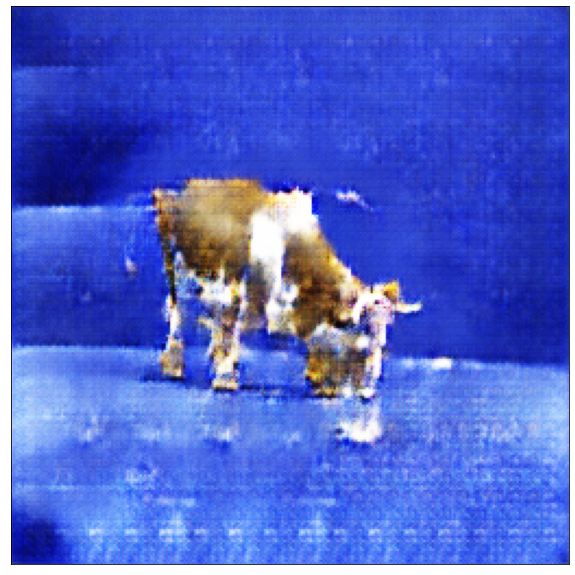

In [59]:
latent = 128
t_latent = torch.randn(1, latent, 1, 1, device=device)
modelcow=torch.load('model_cow30.pt')
t=modelcow(t_latent)
show_images(t)

# CNN WITH GAN Data AUGMENTATION

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
image_size = 256
batch_size = 32 #number of image for each trainning
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean
DIR_All='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/TRAINNING_withGAN/Data_Train'
folder_All = ImageFolder(DIR_All, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
train_All = DataLoader(folder_All, batch_size, shuffle=True, num_workers=3)#, pin_memory=True)

* The process is applied similarly compared to the case without GAN, but this time, the batch size is increased to 32 to be suitable with the new total dataset augmented to 256 images for each classes.

In [25]:
DIR_Test='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/Newdata/Test'
folder_Test = ImageFolder(DIR_Test, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
test_All = DataLoader(folder_Test, batch_size, shuffle=False, num_workers=3)#, pin_memory=True)

In [26]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

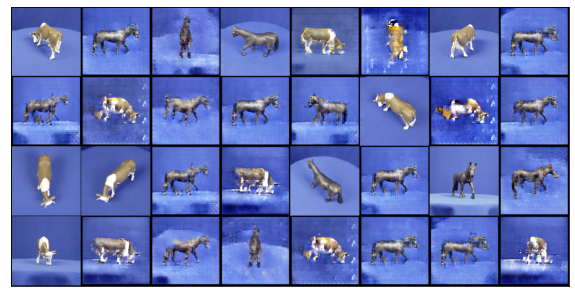

In [27]:
show_batch(train_All)

* Therefore, as can be seen in this batch representation, each batch contains both the original data set and the added ones with the combination of both classes labeled separately by different files.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Sublayer(nn.Module):
    def __init__(self, input_channels):
        super(Sublayer, self).__init__()
        self.conv = nn.Conv2d(input_channels, input_channels*2, 4, 2, 1)
        self.batch= nn.BatchNorm2d(input_channels*2)
        self.relu =nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x
    def get_self(self):
        return self
    
class NetClass(nn.Module):
    def __init__(self):
        super(NetClass, self).__init__()
        self.conv = nn.Conv2d(3, 16, 4, 2, 1)
        self.batch= nn.BatchNorm2d(16)
        self.relu =nn.ReLU(True)
        self.lay1=Sublayer(16)
        self.lay2=Sublayer(32)
        self.lay3=Sublayer(64)
        self.lay4=Sublayer(128)
        self.lay5=Sublayer(256)
        self.lay6=Sublayer(512)
        self.maxpool =nn.MaxPool2d((2,2))
        self.fc = nn.Linear(1024,2)
    def forward(self,x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.lay1(x)
        x = self.lay2(x)
        x = self.lay3(x)
        x = self.lay4(x)
        x = self.lay5(x)
        x = self.lay6(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), 1024)
        x = self.fc(x)
        return x
net = NetClass()

In [10]:
#pip install torchsummary

In [22]:
from torchsummary import summary
model=NetClass()
summary(model,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             784
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4           [-1, 32, 64, 64]           8,224
       BatchNorm2d-5           [-1, 32, 64, 64]              64
              ReLU-6           [-1, 32, 64, 64]               0
          Sublayer-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 32, 32]          32,832
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
         Sublayer-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 128, 16, 16]         131,200
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [36]:
x = torch.zeros(18, 3, 256, 256)
scores = model(x)
print(scores.shape)

torch.Size([18, 2])


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0002)#, momentum=0.9)

In [28]:
# Train the model
import numpy as np
total_step = len(train_All)
loss_list = []
acc_list = []
num_epochs = 10

for epoch in range(num_epochs):
    for i, (data,label) in enumerate(train_All):
        outputs = net(data)
        loss = criterion(outputs, label)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = label.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == label).sum().item()
        acc_list.append(correct / total)

       
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/10], Step [1/16], Loss: 0.6164, Accuracy: 71.88%
Epoch [1/10], Step [2/16], Loss: 0.7120, Accuracy: 46.88%
Epoch [1/10], Step [3/16], Loss: 0.6386, Accuracy: 65.62%
Epoch [1/10], Step [4/16], Loss: 0.5795, Accuracy: 65.62%
Epoch [1/10], Step [5/16], Loss: 0.6260, Accuracy: 65.62%
Epoch [1/10], Step [6/16], Loss: 0.5384, Accuracy: 75.00%
Epoch [1/10], Step [7/16], Loss: 0.5057, Accuracy: 84.38%
Epoch [1/10], Step [8/16], Loss: 0.5308, Accuracy: 71.88%
Epoch [1/10], Step [9/16], Loss: 0.5749, Accuracy: 65.62%
Epoch [1/10], Step [10/16], Loss: 0.4309, Accuracy: 87.50%
Epoch [1/10], Step [11/16], Loss: 0.4216, Accuracy: 90.62%
Epoch [1/10], Step [12/16], Loss: 0.4676, Accuracy: 84.38%
Epoch [1/10], Step [13/16], Loss: 0.4251, Accuracy: 84.38%
Epoch [1/10], Step [14/16], Loss: 0.3695, Accuracy: 93.75%
Epoch [1/10], Step [15/16], Loss: 0.3685, Accuracy: 93.75%
Epoch [1/10], Step [16/16], Loss: 0.3733, Accuracy: 87.50%
Epoch [2/10], Step [1/16], Loss: 0.3466, Accuracy: 96.88%
Epoch [

Epoch [9/10], Step [12/16], Loss: 0.0754, Accuracy: 100.00%
Epoch [9/10], Step [13/16], Loss: 0.1048, Accuracy: 96.88%
Epoch [9/10], Step [14/16], Loss: 0.0971, Accuracy: 100.00%
Epoch [9/10], Step [15/16], Loss: 0.0974, Accuracy: 100.00%
Epoch [9/10], Step [16/16], Loss: 0.1024, Accuracy: 100.00%
Epoch [10/10], Step [1/16], Loss: 0.0740, Accuracy: 100.00%
Epoch [10/10], Step [2/16], Loss: 0.0701, Accuracy: 100.00%
Epoch [10/10], Step [3/16], Loss: 0.0768, Accuracy: 100.00%
Epoch [10/10], Step [4/16], Loss: 0.0652, Accuracy: 100.00%
Epoch [10/10], Step [5/16], Loss: 0.0699, Accuracy: 100.00%
Epoch [10/10], Step [6/16], Loss: 0.0720, Accuracy: 100.00%
Epoch [10/10], Step [7/16], Loss: 0.0519, Accuracy: 100.00%
Epoch [10/10], Step [8/16], Loss: 0.0593, Accuracy: 100.00%
Epoch [10/10], Step [9/16], Loss: 0.0780, Accuracy: 96.88%
Epoch [10/10], Step [10/16], Loss: 0.0700, Accuracy: 100.00%
Epoch [10/10], Step [11/16], Loss: 0.0618, Accuracy: 100.00%
Epoch [10/10], Step [12/16], Loss: 0.078

In [29]:
net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_All:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(correct/total)

0.7195121951219512


* By enlarging the dataset, the accuracy is witnessed to be enhanced with 71.95%.

In [30]:
PATH = 'CNN_with_GAN.pth'
torch.save(net.state_dict(), PATH)

In [32]:
it=[i for i in range(len(loss_list))]
len(it)

160

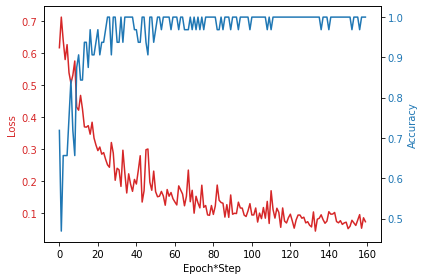

In [33]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch*Step')
ax1.set_ylabel('Loss', color=color)
ax1.plot(it, loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  
ax2.plot(it, acc_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [40]:
torch.save(data_th, 'dataCNN_withGAN.pt')#save the total CNN training data

In [ ]:
predNet=torch.load('CNN_with_GAN.pth')

* The saved model can be loaded to make evaluation on the test dataset. When considering the accuracy of classes separately, it is witnessed that the accuracy of cow is significantly higher (95%) than the average value (71%), which can be resulted from the adequate selection of batch size for training compared to the low performance of the horse GAN data with only about 48%. 

In [ ]:
correct = 0
total = 0
predNet.eval()
with torch.no_grad():
    for data in test_All:
        images, labels = data
        outputs = predNet(images)
        #print(outputs.data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        c = (predicted == labels).sum().item()
        print(c/41)
        #if (predicted !=labels:
        show_images(images[predicted != labels])
correct/total

# UNPAIRED NEURAL STYLE TRANSFER WITH CYCLE GAN

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
class SubLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
class Discriminator(nn.Module):
    def __init__(self,in_channel=3):
        super().__init__()
        self.structure=nn.Sequential(
            nn.Conv2d(in_channel,64,kernel_size=4,stride=2,padding=1,padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True),
            #SubLayer(in_channel,64,stride=1),
            SubLayer(64,128,stride=2),
            SubLayer(128,256,stride=2),
            SubLayer(256,512,stride=1),
            nn.Conv2d(512,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect")
        )
    def forward(self,x):
        x=self.structure(x)
        x=torch.sigmoid(x)
        return x

summary(Discriminator(),(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
          SubLayer-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
         LeakyReLU-9          [-1, 256, 32, 32]               0
         SubLayer-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-12          [-1, 512, 31, 31]               0
        LeakyReLU-13          [-1, 512, 31, 31]               0
         SubLayer-14          [-1, 512,

* The disciminator follows the structure of a PatchGAN containing 3 sublayers (Conv2d, InstanceNorm2d and ReLU) to learn the patch features of the images by extending the channels number through each convolutional layer.
* The output is a (30 by 30) patch matrix containing normalized features (Sigmoid()) of the input batch.

# Generator

In [3]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )
    def forward(self, x):
        return self.conv(x)
class ResidualLayer(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvLayer(channels, channels, kernel_size=3, padding=1),
            ConvLayer(channels, channels, use_act=False, kernel_size=3, padding=1),
        )
    def forward(self, x):
        return x + self.block(x)

* The generator is a CycleGAN structure composed of 3 stages initialized by an encoder to implement a 3-time convolutional decomposition to result in activated values with a 4-th times division size before being transferred in a 6-residual blocks structure with unchanged parameters for transformation and eventually finalized by a decoder which enlarges the residual size back into the original shape in RGB scale of the image by 2 convolution-transpose layers.

In [4]:
class Generator(nn.Module):
    def __init__(self, img_channels=3, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.Sequential(
            ConvLayer(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
            ConvLayer(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
        )
        self.res_blocks = nn.Sequential(
            *[ResidualLayer(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.Sequential(
            ConvLayer(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvLayer(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        x = self.down_blocks(x)
        x = self.res_blocks(x)
        x = self.up_blocks(x)
        x = torch.tanh(self.last(x))
        return x

def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size))
    gen = Generator()
    print(gen(x).shape)

if __name__ == "__main__":
    test()

torch.Size([2, 3, 256, 256])


In [10]:
summary(Generator(),(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-2         [-1, 64, 256, 256]               0
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-5        [-1, 128, 128, 128]               0
              ReLU-6        [-1, 128, 128, 128]               0
         ConvLayer-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
        ConvLayer-11          [-1, 256, 64, 64]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

# DataLoading

In [5]:
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [7]:
device = get_default_device()

In [8]:
device

device(type='cpu')

In [9]:
image_size = 256
batch_size = 1 #number of image for each trainning
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean
DIR_Cow='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/Newdata/Train/Cow_train'
folder_Cow = ImageFolder(DIR_Cow, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
train_Cow = DataLoader(folder_Cow, batch_size, shuffle=True, num_workers=4)#, pin_memory=True)

DIR_Horse='C:/Users/Pro/Desktop/MachineVision/PROJECT_URGENT/TRIN/Newdata/Train/Horse_train'
folder_Horse = ImageFolder(DIR_Horse, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
train_Horse = DataLoader(folder_Horse, batch_size, shuffle=True, num_workers=4)#, pin_memory=True)

In [20]:
disc_H = to_device(Discriminator(), device)#real or fake Horse
disc_C = to_device(Discriminator(), device)#real or fake Cow
gen_H = to_device(Generator(), device)#generate fake Horse
gen_C = to_device(Generator(), device)#generate fake Cow

* As described in the report, there are 2 discriminators and 2 generators defined to generate and differentiate images in both class distribtions (Cow & Horse).

In [11]:
cow_loader = DeviceDataLoader(train_Cow,device)
horse_loader =DeviceDataLoader(train_Horse,device)

* This time, the data of horse and cow is loaded separately to be able to be put into their own discriminators.

In [21]:
import torch.optim as optim
opt_disc = optim.Adam(list(disc_H.parameters())+list(disc_C.parameters()), lr=2e-5,betas=(0.5,0.999))#momentum & beta2
opt_gen = optim.Adam(list(gen_C.parameters())+list(gen_H.parameters()), lr=2e-5,betas=(0.5,0.999))

* Adam is taken as the optimizers for both discriminators and generators. In particular, it considers the parameters combination in discriminators and generators for both distribtions. 

In [32]:
l1=nn.L1Loss()#MAE (mean absolute error) criteration for consistent cycle loss 
mse=nn.MSELoss()#MSE (mean square error) criteration for adversarial loss

In [15]:
lambda_cycle=10#coefficient of importance for consistent cycle loss 
from torchvision.utils import save_image

In [41]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

# Training

In [34]:
num_epochs = 10
Dloss_stored=[]
for epoch in range(num_epochs):
    for i, ((Cow,lc),(Horse,lH)) in enumerate(zip(cow_loader,horse_loader)):
        #consider batches (1 by 1 image) from zipped dataloader of horse and cow
        fake_horse =gen_H(Cow)#generate fake horse from an input cow
        D_H_real =disc_H(Horse)#guess of discriminator for a real horse
        D_H_fake =disc_H(fake_horse.detach())#guess the fake probability of the fake horse generated by a cow
        #to be not repeated the first line while training gen
        D_H_real_loss = mse(D_H_real,torch.ones_like(D_H_real))#attach the correct real label for the real guess
        #and consider the MSE between these labels
        D_H_fake_loss = mse(D_H_fake,torch.zeros_like(D_H_fake))#attach the correct fake label for the fake guess 
        D_H_loss =D_H_real_loss+D_H_fake_loss 
        #disciminator loss to distinguish horse ability is the summation of fake and real cases
        
        #the same procedure is applied for the reverse mapping side of the discriminator to classify cow 
        fake_cow = gen_C(Horse)
        D_C_real =disc_C(Cow)
        D_C_fake =disc_C(fake_cow.detach())#not repeat the first line while training gen
        D_C_real_loss = mse(D_C_real,torch.ones_like(D_C_real))
        D_C_fake_loss = mse(D_C_fake,torch.zeros_like(D_C_fake))
        D_C_loss =D_C_real_loss+D_C_fake_loss
            
        #All D Loss is the average value of disciminator losses of cow and horse
        #these discriminators encourage the ability 
        #to generate a style image for a distribution from the opposite class
        D_loss=(D_H_loss+D_C_loss)/2
            
        opt_disc.zero_grad()
        D_loss.backward()
        opt_disc.step()
        #the general D_loss is optimized and updated step by step 
        
        D_H_fake = disc_H(fake_horse)
        D_C_fake = disc_C(fake_cow)
        loss_G_H = mse(D_H_fake,torch.ones_like(D_H_fake))
        #attach the wrong real label for the fake guess to fool the discriminator
        loss_G_C = mse(D_C_fake,torch.ones_like(D_C_fake))
        #attach the wrong fake label for the real guess
            
        #cycle loss
        cycle_cow =gen_C(fake_horse)#the cow image reconstructed from fakely generated horse from a cow 
        cycle_horse=gen_H(fake_cow)#the horse image reconstructed from fakely generated cow from a horse
        cycle_cow_loss= l1(Cow,cycle_cow)
        #cycle consistent loss of cow is the MAE between the reconstructed cow and its original form
        cycle_horse_loss=l1(Horse,cycle_horse)
        #cycle consistent loss of horse is the MAE between the reconstructed horse and its original form
        #this is conducted to make the generators gen_C and gen_H able to synthesize the same shape of the animal

        #all-in G_loss
        G_loss=(loss_G_C+loss_G_H+cycle_cow_loss*lambda_cycle+cycle_horse_loss*lambda_cycle)
        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()
        #all of these losses are combined and trained iteratively by Adam optimizer
        
        if i%10==0:
            save_image(fake_horse*0.5+0.5,f"saved_images/horse_{epoch}_{i}.png")
            save_image(fake_cow*0.5+0.5,f"saved_images/cow_{epoch}_{i}.png")
        

In [35]:
print(G_loss,D_loss)#2.3977#0.3929

tensor(2.3977, grad_fn=<AddBackward0>) tensor(0.3929, grad_fn=<DivBackward0>)


In [37]:
print(D_H_loss,D_C_loss)#0.4250#0.3608

tensor(0.4250, grad_fn=<AddBackward0>) tensor(0.3608, grad_fn=<AddBackward0>)


In [39]:
print(loss_G_H,loss_G_C)#0.3194#0.3405

tensor(0.3194, grad_fn=<MseLossBackward>) tensor(0.3405, grad_fn=<MseLossBackward>)


In [40]:
print(cycle_cow_loss,cycle_horse_loss)#0.1140#0.0598

tensor(0.1140, grad_fn=<L1LossBackward>) tensor(0.0598, grad_fn=<L1LossBackward>)


In [36]:
PATH1 = 'Generater_Horse.pt'
torch.save(gen_H, PATH1)

PATH2 = 'Generator_Cow.pt'
torch.save(gen_C, PATH2)


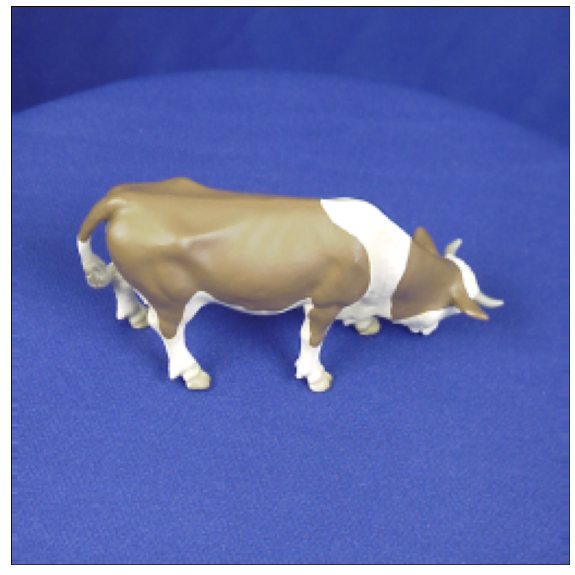

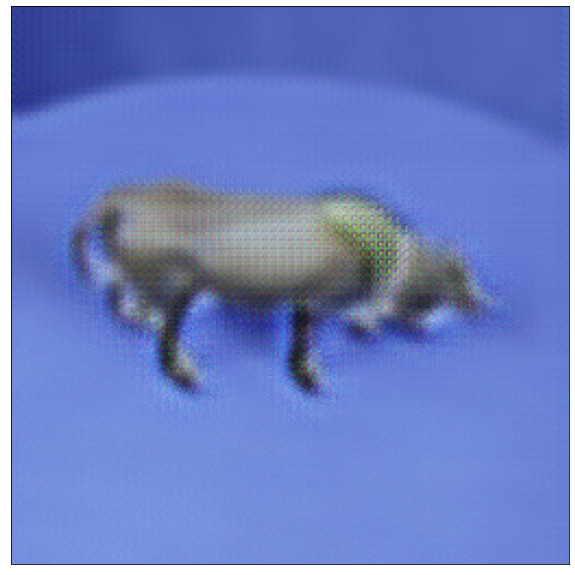

In [52]:
genhorse=torch.load('Generater_Horse.pt')
for i, (Cow,lc) in enumerate(train_Cow):
    if i==1:
        th=Cow
        show_images(th)
        show_images(genhorse(th))

* As can be seen, the style of a horse can be transferred to a certain input animal and still retain its original shape and features of the distribution it belongs to. 

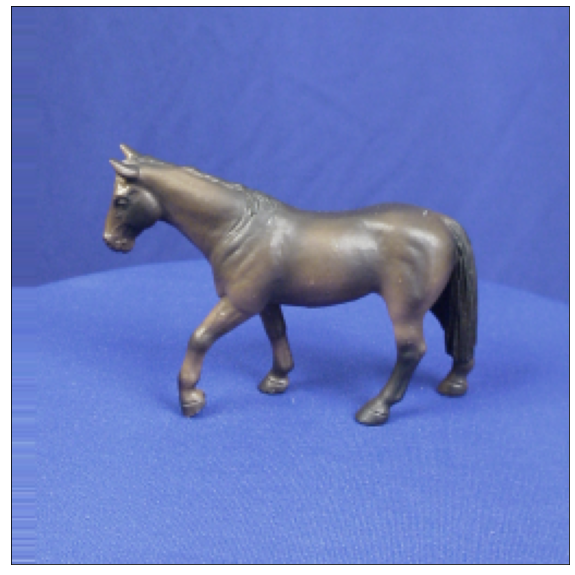

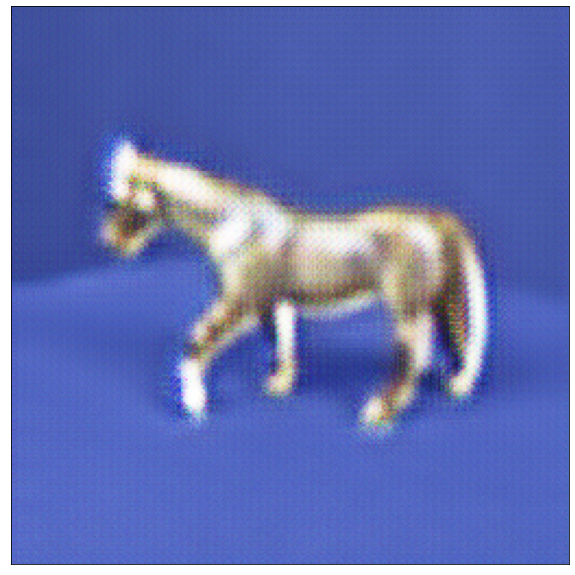

In [49]:
gencow=torch.load('Generator_Cow.pt')
for i, (Horse,lc) in enumerate(train_Horse):
    if i==1:
        th=Horse
        show_images(th)
        show_images(gencow(th))

In [15]:
len(train_All)

82